# Food-101 :: FITBY - Tensorflow Training and Testing

### Problem Statement
<p>
We introduce a challenging data set of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

Final Test Run - 5/3/2022
| RunTime (4375 images) - 01:37:18

Predictor achieved around 60% accuracy on the validation set. Confidence in predicting image of 71%.
</p>

### Dataset

[Training and Test dataset](http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz).
<br>

### Evaluation Metric
 
*** Accuracy ***
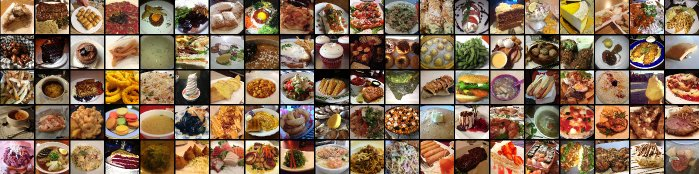

In [1]:
%cd ../input/food-101/food-101/
!ls food-101/

**meta** folder contains the text files - train.txt and test.txt <br>
**train.txt** contains the list of images that belong to training set <br>
**test.txt** contains the list of images that belong to test set <br>
**classes.txt** contains the list of all classes of food <br>

**images** folder contains 101 folders with 1000 images each. <br>
Following Classes of Food items available

In [2]:
!ls food-101/images/

### Data Preparation

In [3]:
from collections import defaultdict
from shutil import copy
import os
import gc

# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
%cd /
print("Creating train data...")
prepare_data('/kaggle/input/food-101/food-101/food-101/meta/train.txt', '/kaggle/input/food-101/food-101/food-101/images', 'train')

In [ ]:
%cd /
print("Creating test data...")
prepare_data('/kaggle/input/food-101/food-101/food-101/meta/test.txt', '/kaggle/input/food-101/food-101/food-101/images', 'test')

In [ ]:
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

### Model

In [ ]:
from fastai.metrics import accuracy
from fastai.vision import *

BS = 16
SEED = 678
NUM_WORKERS = 0

from pathlib import Path
path = Path('/')

In [ ]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0., xtra_tfms=[cutout()])

src = (ImageList.from_folder(path/'train')
       .split_by_rand_pct(0.2)
       .label_from_folder())

data = (src.add_test_folder(test_folder = path/'test')              
         .transform(tfms, size=128)
         .databunch(num_workers=NUM_WORKERS,bs=BS)).normalize(imagenet_stats)

**Creating data bunch with size 128 x 128**

In [ ]:
data.show_batch(3)

In [ ]:
gc.collect()

learner = cnn_learner(
    data,
    models.resnet50,
    path=path,
    metrics=[accuracy],
    ps = 0.5
)

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr = 1e-03
learner.fit_one_cycle(1, slice(lr))

In [ ]:
learner.save('stage-1-rn50')
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(2, slice(1e-5, lr/5))

In [ ]:
learner.save('stage-2-rn50')

**Creating data bunch with size 256 x 256. Feeding the data to the same model we have trained on 128 x 128 images.**

In [ ]:
data = (src.add_test_folder(test_folder = path/'test')              
         .transform(tfms, size=256)
         .databunch(num_workers=NUM_WORKERS,bs=BS)).normalize(imagenet_stats)

learner.data = data

In [ ]:
learner.freeze()
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr=1e-3/2
learner.fit_one_cycle(1, slice(lr))

In [ ]:
learner.save('stage-1-256-rn50')
learner.unfreeze()
learner.fit_one_cycle(2, slice(1e-6, 1e-5/5))

In [ ]:
learner.recorder.plot_losses()
learner.save('stage-2-256-rn50')
learner.export()

**Creating data bunch with size 512 x 512 (Original Image Size). Feeding the data to the same model we have trained on 128 x 128 & 256 x 256 images.**

In [ ]:
data = (src.add_test_folder(test_folder = path/'test')              
         .transform(tfms, size=512)
         .databunch(num_workers=NUM_WORKERS,bs=BS)).normalize(imagenet_stats)

learner.data = data

learner.freeze()
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr=1e-3/2
learner.fit_one_cycle(1, slice(lr))

In [ ]:
learner.save('stage-1-512-rn50')
learner.unfreeze()
learner.fit_one_cycle(2, slice(1e-6, 1e-3/2))

In [ ]:
learner.recorder.plot_losses()
learner.save('stage-2-512-rn50')
learner.export()

**Test Data Accuracy**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

src = (ImageDataBunch.from_folder(path = path, train = 'train', valid = 'test')
       .split_by_rand_pct(0.2)
       .label_from_folder())

data = (src.transform(tfms, size=512)
         .databunch(num_workers=NUM_WORKERS,bs=BS)).normalize(imagenet_stats)

In [ ]:
learner.fit_one_cycle(1)

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    im = open_image(img)                                     

    pred,_,_ = model.predict(im)
    if show:
        plt.imshow(image2np(im.data))                           
        plt.axis('off')
        print(pred)
        plt.show()

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

# list all files in dir
files = [y for x in os.listdir("/test/") for y in os.listdir(os.path.join("/test/", x)) if os.path.isfile(y)]

# select 0.1 of the files randomly 
random_files = np.random.choice(files, int(len(files)*.1))

### Predictions

In [ ]:
predict_class(learner, random_files, True )